# American Sign Language Fingerspelling Recognition

The goal of this competition is to detect and translate American Sign Language (ASL) fingerspelling into text. You will create a model trained on the largest dataset of its kind, released specifically for this competition. The data includes more than three million fingerspelled characters produced by over 100 Deaf signers captured via the selfie camera of a smartphone with a variety of backgrounds and lighting conditions.  

Your work may help move sign language recognition forward, making AI more accessible for the Deaf and Hard of Hearing community.

### Reference:

- Fingerspelling Recognition w/ TensorFlow: [code](https://www.kaggle.com/code/gusthema/asl-fingerspelling-recognition-w-tensorflow)
- A simple transformer: [code](https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer)
- Transformer training & inference: [code](https://www.kaggle.com/code/markwijkhuizen/aslfr-transformer-training-inference)
- Animated visualization: [code](https://www.kaggle.com/code/rafiko1/aslfr-animated-visualization)

# Import Library

In [ ]:
import os
import gc
import json
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import Levenshtein as lev
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from tqdm import tqdm
from leven import levenshtein
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
seed = 40
tf.random.set_seed(seed)

# Data Loading

New tokens for padding, start and end of sentences. (Capitals are good since the original phrases have only lower case letters, besides numbers and various signs).

In [4]:
pad_token   = 'P'
start_token = 'S'
end_token   = 'E'

pad_token_idx   = 59
start_token_idx = 60
end_token_idx   = 61

In [5]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)]

# Pose coordinates for hand movement & Set length of frames to 128
FEATURE_COLUMNS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if  "left" in col]

In [ ]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN - tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x


def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        
        hand_x = hand[:, 0 * (len(LHAND_IDX) // 3) : 1 * (len(LHAND_IDX) // 3)]
        hand_y = hand[:, 1 * (len(LHAND_IDX) // 3) : 2 * (len(LHAND_IDX) // 3)]
        hand_z = hand[:, 2 * (len(LHAND_IDX) // 3) : 3 * (len(LHAND_IDX) // 3)]
        hand = tf.concat([1 - hand_x, hand_y, hand_z], axis=1)
    else:
        hand = rhand
    
    hand_x = hand[:, 0 * (len(LHAND_IDX) // 3) : 1 * (len(LHAND_IDX) // 3)]
    hand_y = hand[:, 1 * (len(LHAND_IDX) // 3) : 2 * (len(LHAND_IDX) // 3)]
    hand_z = hand[:, 2 * (len(LHAND_IDX) // 3) : 3 * (len(LHAND_IDX) // 3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std
    
    # x = tf.concat([hand, pose], axis=1)
    x = tf.concat([hand], axis=1)
    x = resize_pad(x)
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    
    # x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX)))
    return x


def preprocess_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(
        phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode='CONSTANT',
        constant_values = pad_token_idx
    )
    return pre_process(landmarks), phrase


def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    landmarks = tf.transpose(landmarks)
    return landmarks, phrase

# Load the Preprocessed Dataset as TFRecords

Using the extracted landmarks and phrases let us create new dataset files and write them as TFRecords.

In [6]:
dataset_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# Fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]

# Fetch data from parquet file
sample_sequence_df = pq.read_table(
    f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]
).to_pandas()

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(dataset_df.file_id.unique()):
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"

    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    
    # Fetch the parquet file
    parquet_df = pq.read_table(
        f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet",
        columns=['sequence_id'] + FEATURE_COLUMNS
    ).to_pandas()

    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()

    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:

        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):

            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2 * len(phrase) < no_nan:
                features = {
                    FEATURE_COLUMNS[i]: tf.train.Feature(
                        float_list=tf.train.FloatList(value=frames[:, i])
                    ) for i in range(len(FEATURE_COLUMNS))
                }
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

100%|██████████| 68/68 [08:26<00:00,  7.45s/it]


In [7]:
tf_records = df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [8]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

# input_dir = "/kaggle/input/aslfr-parquets-to-tfrecords-cleaned"
tffiles = df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()

batch_size = 32
val_len = int(0.05 * len(tffiles))

train_dataset = tf.data.TFRecordDataset(tffiles[val_len:]).map(decode_fn).map(preprocess_fn).shuffle(30000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.TFRecordDataset(tffiles[:val_len]).map(decode_fn).map(preprocess_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Visualization

In [9]:
def map_new_to_old_style(sequence):
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)


def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x],
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x],
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y],
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y


def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y


def animation_frame(f):
    frame = seq[seq.frame==f]
    left  = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose  = frame[frame.type=='pose']
    face  = frame[frame.type=='face'][['x', 'y']].values

    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)

    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')

    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

In [8]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding').T)

,,!,#,$,%,&,',(,),*,...,r,s,t,u,v,w,x,y,z,~
Ordinal Encoding,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58


In [2]:
# Dataset in train.csv
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [6]:
parquet = pd.read_parquet('/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet')
sequences = list(parquet.index.unique())

# select sequence from parquet file
SELECT = 4
select_seq = sequences[SELECT]

# first sequence
seq = parquet.loc[select_seq]
seq = map_new_to_old_style(seq)
seq.y = seq.y * -1
seq.head()

,frame,type,landmark_index,x,y,z
0,0,face,0,0.707202,-0.436244,-0.044055
1,0,face,1,0.710196,-0.416141,-0.068559
2,0,face,2,0.710963,-0.424626,-0.040114
3,0,face,3,0.695872,-0.396556,-0.046008
4,0,face,4,0.709112,-0.409182,-0.071076


In [12]:
seq['type'].value_counts()

face          70200
pose           4950
left_hand      3150
right_hand     3150
Name: type, dtype: int64

In [10]:
selected_row = df[df['sequence_id'] == select_seq]
selected_row

,path,file_id,sequence_id,participant_id,phrase
30263,train_landmarks/1019715464.parquet,1019715464,1975541698,161,+44-4560-846


The phrase being shown here is: +44-4560-846


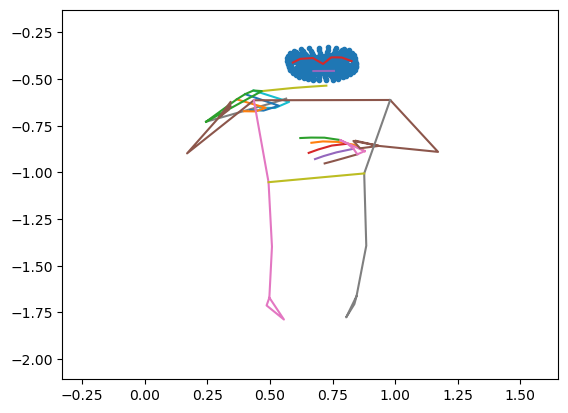

In [11]:
print(f"The phrase being shown here is: {selected_row.phrase.iloc[0]}")

# These values set the limits on the graph to stabilize the video
xmin = seq.x.min() - 0.2
xmax = seq.x.max() + 0.2
ymin = seq.y.min() - 0.2
ymax = seq.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(
    fig, func=animation_frame, 
    frames=seq.frame.unique()
)

HTML(animation.to_html5_video())

# Model

In [9]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        # self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
        '''
        self.pos_emb = tf.math.divide(
            self.positional_encoding(maxlen-1, num_hid),
            tf.math.sqrt(tf.cast(num_hid, tf.float32)))
        '''
        self.pos_emb = self.positional_encoding(maxlen-1, num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        '''
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
        '''
        return x + self.pos_emb[:maxlen, :]
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid / 2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :] / depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1
        ) 
        return pos_encoding


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.pos_emb = self.positional_encoding(maxlen, num_hid)
        self.maxlen = maxlen
        self.num_hid = num_hid

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        x = x + self.pos_emb
        return x
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid / 2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :] / depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1
        ) 
        return pos_encoding

In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(feed_forward_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [11]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential([
            layers.Dense(feed_forward_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """
        Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

In [12]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(
            num_hid=num_hid, maxlen=source_maxlen
        )
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """ Processes one batch inside model.fit(). """
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """ Performs inference over one batch of inputs using greedy decoding. """
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for _ in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

# Training

In [13]:
batch = next(iter(val_dataset))
idx_to_char = list(char_to_num.keys())

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen=FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62,
)

In [14]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

In [15]:
%%time
history = model.fit(
    train_dataset, verbose=2, epochs=13,
    validation_data=val_dataset
)

Epoch 1/13
1520/1520 - 166s - loss: 0.7841 - val_loss: 0.6439 - 166s/epoch - 109ms/step
Epoch 2/13
1520/1520 - 145s - loss: 0.5726 - val_loss: 0.5392 - 145s/epoch - 95ms/step
Epoch 3/13
1520/1520 - 143s - loss: 0.5093 - val_loss: 0.5001 - 143s/epoch - 94ms/step
Epoch 4/13
1520/1520 - 144s - loss: 0.4809 - val_loss: 0.4837 - 144s/epoch - 95ms/step
Epoch 5/13
1520/1520 - 146s - loss: 0.4620 - val_loss: 0.4719 - 146s/epoch - 96ms/step
Epoch 6/13
1520/1520 - 145s - loss: 0.4480 - val_loss: 0.4654 - 145s/epoch - 95ms/step
Epoch 7/13
1520/1520 - 145s - loss: 0.4366 - val_loss: 0.4594 - 145s/epoch - 95ms/step
Epoch 8/13
1520/1520 - 145s - loss: 0.4269 - val_loss: 0.4535 - 145s/epoch - 95ms/step
Epoch 9/13
1520/1520 - 145s - loss: 0.4182 - val_loss: 0.4523 - 145s/epoch - 95ms/step
Epoch 10/13
1520/1520 - 145s - loss: 0.4105 - val_loss: 0.4485 - 145s/epoch - 95ms/step
Epoch 11/13
1520/1520 - 145s - loss: 0.4031 - val_loss: 0.4508 - 145s/epoch - 95ms/step
Epoch 12/13
1520/1520 - 145s - loss: 0.3

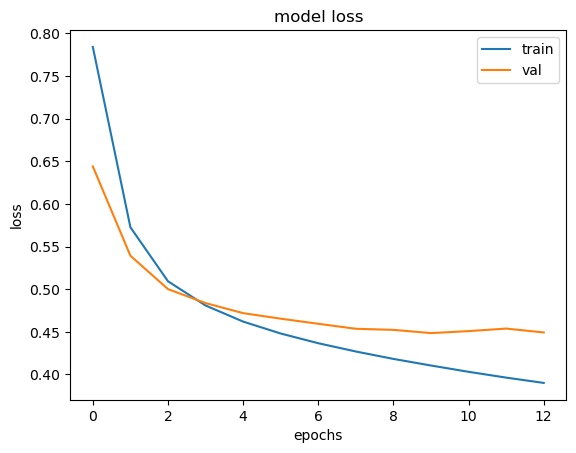

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.title("model loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Model Architecture

In [17]:
# Model Layer Names
for layer in model.layers:
    print(layer.name)

landmark_embedding
token_embedding
sequential_2
transformer_decoder
dense_6


In [18]:
model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding (Landmar  (None, 128, 200)         1019200   
 kEmbedding)                                                     
                                                                 
 token_embedding (TokenEmbed  multiple                 12400     
 ding)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 128, 200)          2627200   
                                                                 
 transformer_decoder (Transf  multiple                 1447000   
 ormerDecoder)                                                   
                                                                 
 dense_6 (Dense)             multiple                  12462     
                                                       

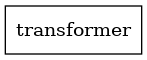

In [19]:
# Plot Model Architecture
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True, 
    expand_nested=True, show_layer_activations=True
)

# Validation

In [20]:
batches = [batch for batch in val_dataset]

predictions_list  = []
ground_truth_list = []

LD_TRAIN = []
for batch in batches[:1]:
    source = batch[0]
    target = batch[1].numpy()

    bs = tf.shape(source)[0]
    preds = model.generate(source, start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        target_text = target_text.replace('P', '')
        ground_truth_list.append(target_text)
        
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == end_token_idx:
                break
        predictions_list.append(prediction)
        LD_TRAIN.append({
            "Ground_Truth": ground_truth_list[-1][1:-1],
            "Predicttion" : predictions_list[-1][1:-1],
            "Levenshtein" : levenshtein(prediction[1:-1], target_text[1:-1])
        })

# Convert to DataFrame
LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)

for i in range(5):
    print(f"Ground Truth : {ground_truth_list[i][1:-1]}")
    print(f"Prediction   : {predictions_list[i][1:-1]}")
    print(f'{"-" * 12}\n')

Ground Truth : 3 creekhouse
Prediction   : 3 creek house
------------

Ground Truth : scales/kuhaylah
Prediction   : scalespochapporhayla
------------

Ground Truth : 1383 william lanier
Prediction   : 1385 william lany lanier
------------

Ground Truth : 988 franklin lane
Prediction   : 988 frankan stane
------------

Ground Truth : 6920 northeast 661st road
Prediction   : 6920 northeast 66th road
------------



## Levenstein Distance

The evaluation metric equals `(N - D) / N`

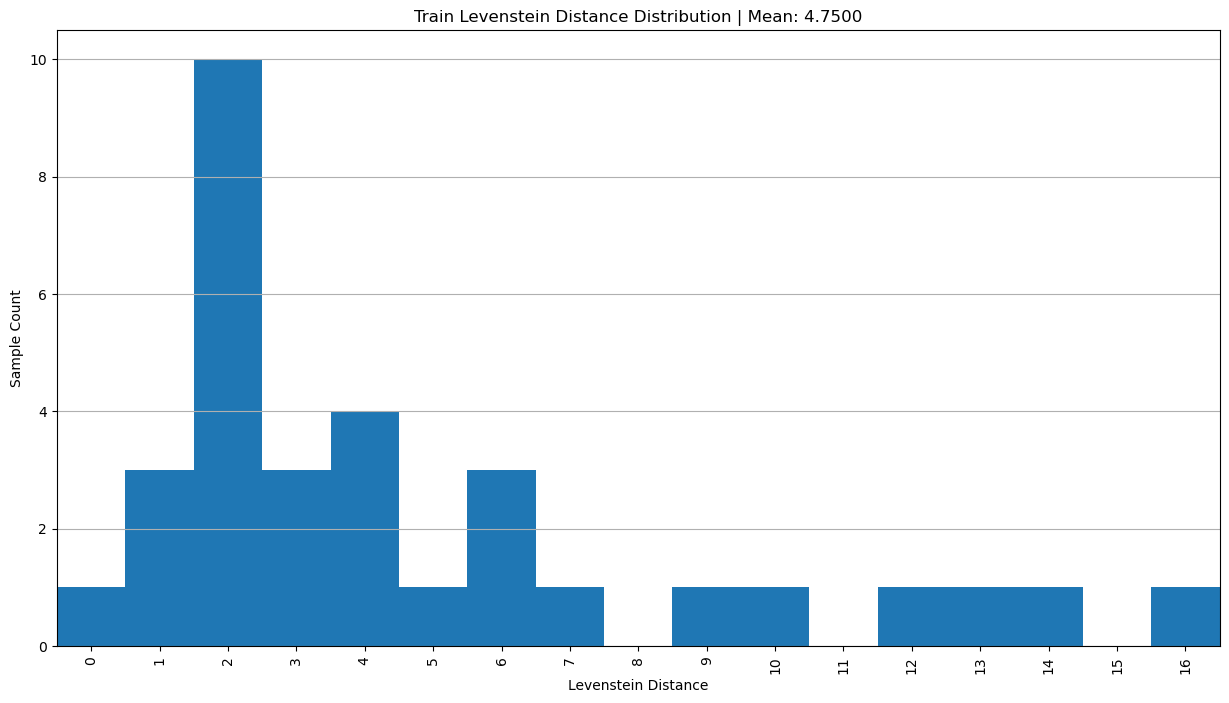

In [21]:
# Value Counts Levenshtein
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['Levenshtein'].max() + 1)])
for ld in LD_TRAIN_DF['Levenshtein']:
    LD_TRAIN_VC[ld] += 1

# Plot Distance Distribution
plt.figure(figsize=(15, 8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.Levenshtein.mean():.4f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.Levenshtein.max() + 0.50)
plt.grid(axis='y')
plt.show()

In [22]:
ground_truth_processed = [ground_truth_list[i][1:-1] for i in range(len(ground_truth_list))]
preds_list_processed   = [predictions_list[i][1:-1]  for i in range(len(predictions_list))]

lev_dist = [
    lev.distance(ground_truth_processed[i], preds_list_processed[i]) 
    for i in range(len(preds_list_processed))
]

N = [len(phrase) for phrase in ground_truth_processed]
print(f'Validation score: {(np.sum(N) - np.sum(lev_dist)) / np.sum(N):.2%}\n')

# Display Errors
display(LD_TRAIN_DF.head(30))

Validation score: 73.93%



,Ground_Truth,Predicttion,Levenshtein
0,3 creekhouse,3 creek house,1
1,scales/kuhaylah,scalespochapporhayla,10
2,1383 william lanier,1385 william lany lanier,6
3,988 franklin lane,988 frankan stane,4
4,6920 northeast 661st road,6920 northeast 66th road,3
5,www.freem.ne.jp,www.freeme.it,4
6,https://jsi.is/hukuoka,https://jssi.issis/huroka,6
7,239613 stolze street,2961 3r stole strest reet,9
8,271097 bayshore boulevard,271097 bay hore boulevard rd,4
9,federico pearson,federico pearon,1


# TFLite Model

In [23]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx

        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}

# Define TF Lite Model
tflitemodel_base = TFLiteModel(model)

## Save Model Weight

In [24]:
model.save_weights("model.h5")

In [25]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}
with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [26]:
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 19%)
  adding: inference_args.json (deflated 86%)


## Inference

In [3]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i, j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())
if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

# Print the shape of sequence_of_landmarks for debugging
inference_idx = 0
print("Input shape:", batch[0][inference_idx].shape)

# Prediction is batch[0]
prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][inference_idx])
characters_idx = [char_idx for char_idx in np.argmax(output[REQUIRED_OUTPUT], axis=1)]
prediction_str = "".join([rev_character_map.get(s, "") for s in characters_idx])
print(f"Prediction: {prediction_str}")

Input shape: (128, 63)
Prediction: 13 apper


In [29]:
# Ground Truth is batch[1]
target = batch[1][inference_idx].numpy()
target_text = "".join([rev_character_map.get(idx, "") for idx in target])
target_text = target_text.replace('P', '')
print(f"Ground Truth: {target_text[1:-1]}")

Ground Truth: 3 creekhouse


In [1]:
count_target = 0

# Predict first 10 validate dataset
for frame, target in val_dataset.take(10):
    output = prediction_fn(inputs=frame)
    output = np.argmax(output[REQUIRED_OUTPUT], axis=1)
    prediction_str = "".join([rev_character_map.get(s, "") for s in output])

    target = target.numpy()
    target_text = "".join([rev_character_map.get(idx, "") for idx in target[count_target]])
    target_text = target_text.replace('P', '')
    count_target += 1

    # Print prediction and ground truth
    print(f"predict = {prediction_str}\ntarget = {target_text}\n")

predict = 13 apper
target = 3 creekhouse

predict = /4565-446
target = +677-256-09-109-015-266

predict = 565 benue armane
target = 927 ernest surrency

predict = /heumpsu/
target = 8004 tonkaway

predict = 149-442-4205
target = nyelvmuveles.hu

predict = /himarer
target = nauka/amatersky-volejbal-4-2

predict = 2466 court
target = ppe/raul.moralopez.5/

predict = 344-363-4436
target = 1536 sheldon center

predict = /hamarisha/
target = idg.timedg.com/

predict = +64-44-542-52
target = 1099 decca lane



# End of the Notebook